In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')
df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)

with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)
    
# import sys
# sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
# from utils import plot_ellipse, smooth, tilt_distance_LI, compute_tilt_data, bearing


In [14]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [3]:
sample_eddies = [66, 425, 871, 1780, 31, 182, 1602, 2128]
dic_sample = {}
for eddy in sample_eddies:
    eddy = f'Eddy{eddy}'
    dic_sample[eddy] = dic_eddies_vert[eddy]
    

In [23]:
mask = np.abs(z_r) < 1000
depth = np.abs(z_r[mask])
n = depth.size

base = pd.DataFrame({"Depth": depth})
frames = []

for eddy, dic in dic_sample.items():
    for d, (df, day) in enumerate(zip(dic.values(), dic.keys())):
        if df.empty:
            continue
        day = int(day[3:])
        df2 = df.loc[df["Depth"].abs() < 1000, ["x", "y"]].reset_index(drop=True)
        tmp = df2.reindex(range(n))  # pad with NaNs to match depth levels
        tmp.columns = [f"{eddy}_Day{day}_x", f"{eddy}_Day{day}_y"]
        frames.append(tmp)

df_depths = pd.concat([base, *frames], axis=1, copy=False)
df_depths


,Depth,Eddy66_Day1674_x,Eddy66_Day1674_y,Eddy66_Day1675_x,Eddy66_Day1675_y,Eddy66_Day1676_x,Eddy66_Day1676_y,Eddy66_Day1679_x,Eddy66_Day1679_y,Eddy66_Day1680_x,...,Eddy2128_Day8966_x,Eddy2128_Day8966_y,Eddy2128_Day8967_x,Eddy2128_Day8967_y,Eddy2128_Day8968_x,Eddy2128_Day8968_y,Eddy2128_Day8969_x,Eddy2128_Day8969_y,Eddy2128_Day8970_x,Eddy2128_Day8970_y
0,1.783320,838.082945,1463.359042,841.944207,1458.453989,845.647270,1457.132245,844.231507,1488.502854,839.416705,...,253.084486,567.480090,241.881085,536.699813,238.604963,523.279677,240.586005,517.400123,242.627058,498.439709
1,5.879627,838.449025,1462.889245,842.548504,1458.370782,846.492748,1457.401894,844.139211,1487.952266,839.914092,...,247.609623,560.154560,240.715586,532.490102,238.290099,522.534501,239.280399,516.258631,243.434436,499.768934
2,10.725783,838.490020,1462.700349,842.953076,1458.517750,846.865130,1457.608137,844.148262,1487.665062,840.245640,...,246.281557,545.042801,240.745331,532.123683,238.367262,522.731495,239.246365,516.226479,243.800521,500.998354
3,16.383097,838.643865,1462.945791,843.346376,1458.755273,847.123878,1457.839066,844.146417,1487.423538,840.456378,...,243.799958,535.565244,240.616023,531.272790,238.396574,522.900646,239.201841,516.231714,243.843124,502.265386
4,22.925581,838.758631,1462.524487,843.581149,1458.630220,847.346424,1458.110049,844.146634,1487.093842,840.741524,...,243.910670,532.647053,240.598377,530.937821,238.286392,522.686191,239.195147,516.253579,243.571661,503.336370
5,30.444118,838.899192,1462.704843,843.973783,1459.065805,848.195131,1460.480151,844.096139,1486.861545,840.803457,...,243.769833,530.865328,240.644250,530.863947,238.164996,522.375225,239.006638,516.161120,243.011629,503.642985
6,39.052712,839.117184,1462.531297,844.352940,1459.700432,848.259160,1462.114486,844.007418,1486.672237,840.963613,...,243.670698,529.715716,240.596766,530.618297,238.173968,522.198867,238.825620,516.215450,242.030140,503.900624
7,48.897638,839.480305,1462.474008,844.380259,1461.188048,848.335503,1462.858759,843.788228,1486.529163,841.421390,...,243.619169,529.028098,240.506829,530.299263,238.209823,522.420784,238.481207,516.020812,241.513391,503.474732
8,60.170639,840.037014,1462.728148,844.866533,1462.552153,848.400615,1465.279241,843.360048,1486.256158,841.036146,...,243.535369,528.354243,240.444449,530.076358,238.148097,522.564441,238.168532,515.534681,241.119982,502.661505
9,73.127842,841.301853,1463.629237,845.664766,1464.587517,848.068300,1469.311099,842.087392,1485.073831,842.182898,...,243.429020,527.584898,240.481575,530.022219,237.992685,522.612111,238.053530,515.256108,240.797998,502.139416


In [39]:
def add_center_N2_columns(
    df_depths,
    df_eddies,
    X_grid,
    Y_grid,
    mask_rho,
    z_r,
    base_path,
    varname="N2",
    depth_max=1000,
):
    z1d = np.abs(z_r)
    maskz = z1d < depth_max
    depth = z1d[maskz]
    iz = np.flatnonzero(maskz)
    n = iz.size

    X = np.asarray(X_grid)
    Y = np.asarray(Y_grid)
    wet = np.asarray(mask_rho).astype(bool)

    Xf = X[wet].ravel()
    Yf = Y[wet].ravel()
    wet_idx = np.flatnonzero(wet)
    shp = X.shape

    try:
        from scipy.spatial import cKDTree
        tree = cKDTree(np.c_[Xf, Yf])
        def nearest_ij(xc, yc):
            _, k = tree.query([xc, yc])
            return np.unravel_index(wet_idx[k], shp)
    except Exception:
        def nearest_ij(xc, yc):
            d2 = (Xf - xc) ** 2 + (Yf - yc) ** 2
            k = int(np.nanargmin(d2))
            return np.unravel_index(wet_idx[k], shp)

    valid_pairs = set(
        df_eddies.loc[~df_eddies["TiltDis"].isna(), ["Eddy", "Day"]]
        .itertuples(index=False, name=None)
    )

    key2fname = (
        df_eddies[["Eddy", "Day", "fname"]]
        .dropna(subset=["fname"])
        .drop_duplicates(["Eddy", "Day"])
        .set_index(["Eddy", "Day"])["fname"]
    )

    # build columns here, concat once at end
    cols = {}

    # optional: cache loaded N2 arrays by fnumber to avoid repeated loads
    N2_cache = {}

    for col in df_depths.columns:
        if not col.endswith("_x"):
            continue

        base = col[:-2]
        ycol = base + "_y"
        outcol = base + "_N2"

        vals = np.full(n, np.nan)

        try:
            eddy = int(base.split("_Day")[0].replace("Eddy", ""))
            day  = int(base.split("_Day")[1])
        except Exception:
            cols[outcol] = vals
            continue

        if (eddy, day) not in valid_pairs or (eddy, day) not in key2fname.index:
            cols[outcol] = vals
            continue

        fname = str(key2fname.loc[(eddy, day)])
        fnumber = int(fname[-8:-3])
        base_day = fnumber + 1
        t_idx = int(day - base_day)

        if fnumber not in N2_cache:
            N2 = np.load(f"{base_path}/{varname}_{fnumber:05}.npy")  # (x,y,z,t)
            N2 = np.where(wet[:, :, None, None], N2, np.nan)
            N2_cache[fnumber] = N2
        else:
            N2 = N2_cache[fnumber]

        if t_idx < 0 or t_idx >= N2.shape[3]:
            cols[outcol] = vals
            continue

        xs = df_depths[col].to_numpy()
        ys = df_depths[ycol].to_numpy()

        kk = np.flatnonzero(np.isfinite(xs) & np.isfinite(ys))
        for k in kk:
            ic, jc = nearest_ij(xs[k], ys[k])
            vals[k] = N2[ic, jc, iz[k], t_idx]

        cols[outcol] = vals

    df_N2s = pd.concat([pd.DataFrame({"Depth": depth}), pd.DataFrame(cols)], axis=1)
    return df_N2s



In [40]:
df_N2s = add_center_N2_columns(
    df_depths=df_depths,
    df_eddies=df_eddies,
    X_grid=X_grid,
    Y_grid=Y_grid,
    mask_rho=mask_rho,
    z_r=z_r,
    base_path="/srv/scratch/z5297792/Climatology/N2s/N2s",
    varname="N2",
    depth_max=1000,
)


In [41]:
df_N2s


,Depth,Eddy66_Day1674_N2,Eddy66_Day1675_N2,Eddy66_Day1676_N2,Eddy66_Day1679_N2,Eddy66_Day1680_N2,Eddy66_Day1681_N2,Eddy66_Day1682_N2,Eddy66_Day1683_N2,Eddy66_Day1684_N2,...,Eddy2128_Day8960_N2,Eddy2128_Day8961_N2,Eddy2128_Day8962_N2,Eddy2128_Day8963_N2,Eddy2128_Day8964_N2,Eddy2128_Day8966_N2,Eddy2128_Day8967_N2,Eddy2128_Day8968_N2,Eddy2128_Day8969_N2,Eddy2128_Day8970_N2
0,1.783320,NaN,NaN,NaN,0.000036,0.000038,0.000034,0.000035,0.000035,0.000036,...,0.000040,0.000041,0.000043,0.000037,0.000037,0.000041,0.000056,NaN,NaN,NaN
1,5.879627,NaN,NaN,NaN,0.000040,0.000040,0.000039,0.000039,0.000039,0.000039,...,0.000041,0.000042,0.000043,0.000040,0.000040,0.000041,0.000045,NaN,NaN,NaN
2,10.725783,NaN,NaN,NaN,0.000040,0.000041,0.000040,0.000040,0.000040,0.000040,...,0.000041,0.000042,0.000043,0.000041,0.000041,0.000045,0.000042,NaN,NaN,NaN
3,16.383097,NaN,NaN,NaN,0.000041,0.000041,0.000040,0.000040,0.000040,0.000041,...,0.000042,0.000042,0.000043,0.000041,0.000041,0.000042,0.000042,NaN,NaN,NaN
4,22.925581,NaN,NaN,NaN,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,...,0.000042,0.000042,0.000044,0.000042,0.000041,0.000043,0.000042,NaN,NaN,NaN
5,30.444118,NaN,NaN,NaN,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,...,0.000042,0.000042,0.000044,0.000042,0.000041,0.000042,0.000042,NaN,NaN,NaN
6,39.052712,NaN,NaN,NaN,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,...,0.000042,0.000042,0.000043,0.000042,0.000042,0.000043,0.000042,NaN,NaN,NaN
7,48.897638,NaN,NaN,NaN,0.000041,0.000042,0.000041,0.000041,0.000041,0.000041,...,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,NaN,NaN,NaN
8,60.170639,NaN,NaN,NaN,0.000042,0.000041,0.000041,0.000041,0.000041,0.000041,...,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,NaN,NaN,NaN
9,73.127842,NaN,NaN,NaN,0.000043,0.000042,0.000041,0.000041,0.000041,0.000041,...,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,NaN,NaN,NaN


In [42]:
def bundle_xyN2(df_depths, df_N2s):
    out_parts = [df_depths[["Depth"]].copy()]

    for n2col in df_N2s.columns:
        if not n2col.endswith("_N2"):
            continue

        # keep only if there is at least one finite N2 value
        if not np.isfinite(df_N2s[n2col].to_numpy()).any():
            continue

        base = n2col[:-3]          # strip "_N2"
        xcol = base + "_x"
        ycol = base + "_y"

        if xcol not in df_depths.columns or ycol not in df_depths.columns:
            continue

        out_parts.append(
            pd.concat(
                [df_depths[[xcol, ycol]], df_N2s[[n2col]]],
                axis=1,
                copy=False,
            )
        )

    return pd.concat(out_parts, axis=1, copy=False)

df_bundled = bundle_xyN2(df_depths, df_N2s)
df_bundled


,Depth,Eddy66_Day1679_x,Eddy66_Day1679_y,Eddy66_Day1679_N2,Eddy66_Day1680_x,Eddy66_Day1680_y,Eddy66_Day1680_N2,Eddy66_Day1681_x,Eddy66_Day1681_y,Eddy66_Day1681_N2,...,Eddy2128_Day8963_N2,Eddy2128_Day8964_x,Eddy2128_Day8964_y,Eddy2128_Day8964_N2,Eddy2128_Day8966_x,Eddy2128_Day8966_y,Eddy2128_Day8966_N2,Eddy2128_Day8967_x,Eddy2128_Day8967_y,Eddy2128_Day8967_N2
0,1.783320,844.231507,1488.502854,0.000036,839.416705,1491.942254,0.000038,836.096674,1483.257039,0.000034,...,0.000037,265.032192,533.674352,0.000037,253.084486,567.480090,0.000041,241.881085,536.699813,0.000056
1,5.879627,844.139211,1487.952266,0.000040,839.914092,1490.084061,0.000040,838.050758,1481.657212,0.000039,...,0.000040,262.069103,537.003993,0.000040,247.609623,560.154560,0.000041,240.715586,532.490102,0.000045
2,10.725783,844.148262,1487.665062,0.000040,840.245640,1489.098221,0.000041,839.592446,1480.743556,0.000040,...,0.000041,260.541723,538.481035,0.000041,246.281557,545.042801,0.000045,240.745331,532.123683,0.000042
3,16.383097,844.146417,1487.423538,0.000041,840.456378,1488.350382,0.000041,840.096877,1480.981150,0.000040,...,0.000041,259.369582,539.377226,0.000041,243.799958,535.565244,0.000042,240.616023,531.272790,0.000042
4,22.925581,844.146634,1487.093842,0.000041,840.741524,1487.577464,0.000041,840.506212,1480.655977,0.000041,...,0.000042,258.368574,539.801509,0.000041,243.910670,532.647053,0.000043,240.598377,530.937821,0.000042
5,30.444118,844.096139,1486.861545,0.000041,840.803457,1487.824070,0.000041,841.097856,1479.999728,0.000041,...,0.000042,257.523483,540.162549,0.000041,243.769833,530.865328,0.000042,240.644250,530.863947,0.000042
6,39.052712,844.007418,1486.672237,0.000041,840.963613,1487.207580,0.000041,841.366627,1479.756382,0.000041,...,0.000042,257.004899,540.228201,0.000042,243.670698,529.715716,0.000043,240.596766,530.618297,0.000042
7,48.897638,843.788228,1486.529163,0.000041,841.421390,1485.597917,0.000042,841.332521,1480.285026,0.000041,...,0.000042,256.326108,540.334124,0.000042,243.619169,529.028098,0.000042,240.506829,530.299263,0.000042
8,60.170639,843.360048,1486.256158,0.000042,841.036146,1485.255167,0.000041,841.756075,1479.278788,0.000041,...,0.000042,255.684330,540.328904,0.000042,243.535369,528.354243,0.000042,240.444449,530.076358,0.000042
9,73.127842,842.087392,1485.073831,0.000043,842.182898,1483.651567,0.000042,841.416995,1479.417949,0.000041,...,0.000042,255.141743,540.192133,0.000042,243.429020,527.584898,0.000042,240.481575,530.022219,0.000042


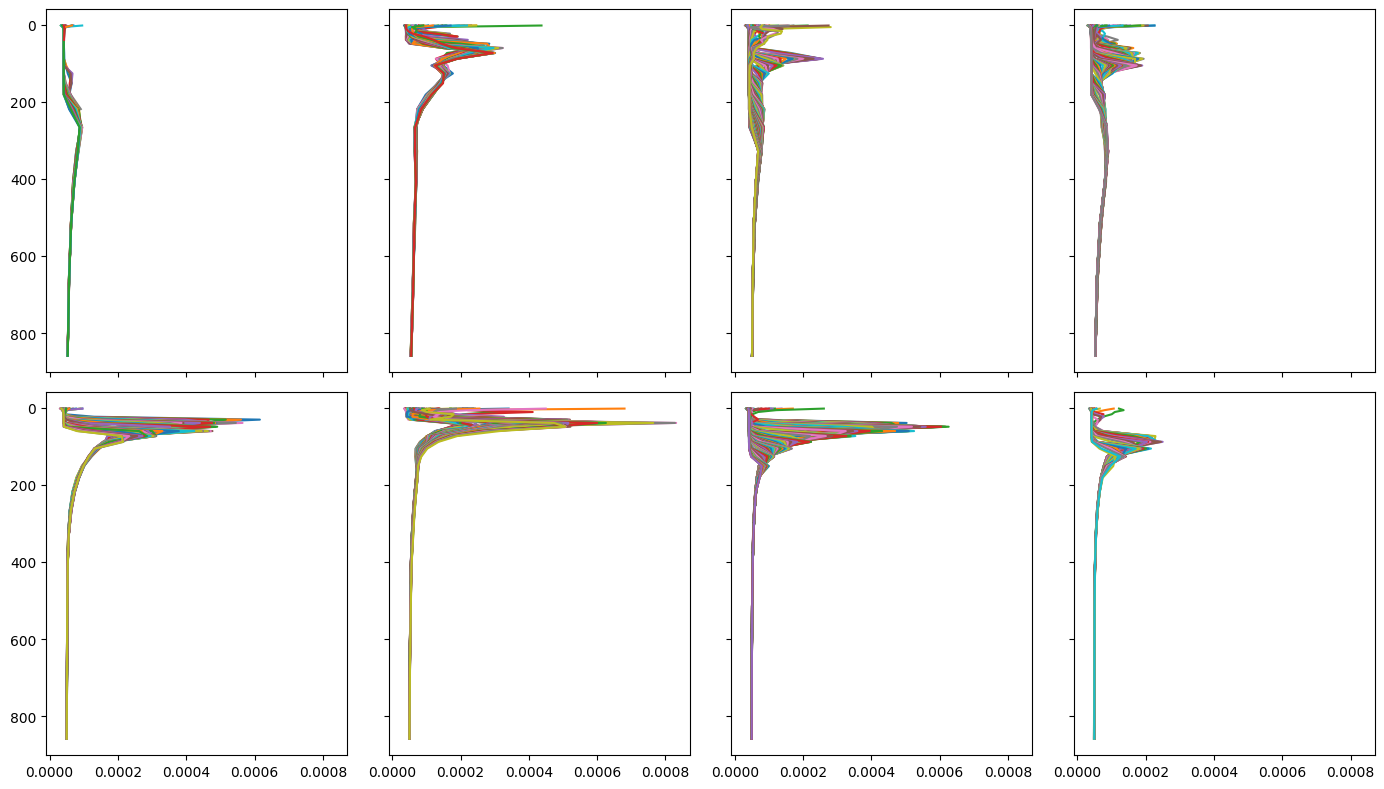

In [70]:
fig, axs = plt.subplots(2, 4, sharey=True, sharex=True, figsize=(14,8))
axs = axs.flatten()
for k, n2col in enumerate(df_bundled.columns):
    if k !=0:
        eddy_id = int(n2col.split("_")[0].replace("Eddy", ""))
        p = np.where([eddy_id==i for i in sample_eddies])[0][0]
        if n2col.endswith("_N2"):
            axs[p].plot(df_bundled[f'{n2col}'], df_bundled.Depth)
axs[0].invert_yaxis()
plt.tight_layout()
